## Backprojection Using Measured Antenna Characteristics
### Estimating missing measurements
Since the antenna characteristics are sparse, some interpolation is necessary.
Let $g_k \in \mathbb C^{P}$ be a vector containing all measurements for $P$ different points.
Our estimate of the total antenna gain is $\hat g_p(k) = a_k \cdot \frac {e^{-j(\omega_0+\beta\tau_{kp})\tau_{kp}}} {r^2_{kp}} =: a_k f_{p}(k)$ where $a_k$ is an arbritary channel weight. In vector notation:
$$
\begin{align}
     \mathbf{\hat gf} &= a \mathbf{f} \\
    \iff  \mathbf{\hat gf} &= a \mathbf{f}^H \mathbf{f} \\
    \iff \frac{\mathbf{\hat gf}} {\mathbf{f}^H \mathbf{f}} &= a
\end{align}
$$


In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, numpy


# setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
nfft = 2**18
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
ramp_slope = (f_end-f_start) / t_chirp
beta = 2*pi*ramp_slope
hertz_per_meter = ramp_slope / lightspeed
bins_per_meter = nfft / maxdist
do_unwrap = True
fs = 22e6
Ts = 1/fs
folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
dists = [2.143, 8.099, 18.016, 32.284]

angles = [pickle.load(open(folder+f'a{int(dist):02d}_angle.pkl', 'rb')) for dist in dists]
degs = [list(map(lambda a : round(a*180/pi - 90), angle)) for angle in angles]
l_degs = [[deg.index(a) for a in sorted(set(deg)) if -60<a<60] for deg in degs]
l_sels = [[l for l,a in enumerate(angle) if -50<180/pi*a-90<50] for angle in angles]
angles_filtered = [[angle[l] for l in l_deg] for angle,l_deg in zip(angles,l_degs)]
#angles_filtered = [[angle[l] for l in l_sel] for angle,l_sel in zip(angles,l_sels)]
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']

cpu


In [4]:
# gains = []
# taus = []
# for dist, angle, l_deg in zip(dists, angles_filtered, l_degs):
#     print('loading fft')
#     fft = torch.load(f'{folder}a{int(dist):02d}_bp_fft.pt')[:,:,l_deg]
#     M,K,L = fft.shape
#     print('computing m_refl')
#     m_refl = fft.abs().flatten(1).argmax(0)
#     print('extracting gains')
#     gain=fft.flatten(1)[m_refl,range(K*L)].unflatten(0, (K,L))
#     del fft
#     tau=2*(m_refl/bins_per_meter + int(dist)-0.5)/lightspeed
#     gains.append(gain)
#     taus.append(tau)

In [5]:
folder = '/home/dgotzens/scripts/3.1_imaging/measured_gains/'
# with open(folder+'gains.pkl', 'wb') as f:
#     pickle.dump(gains,f)
# with open(folder+'taus.pkl', 'wb') as f:
#     pickle.dump(taus,f)
with open(folder+'gains.pkl', 'rb') as f:
    gains = pickle.load(f)
with open(folder+'taus.pkl', 'rb') as f:
    taus = pickle.load(f)

In [28]:
folder = '/home/dgotzens/recording/'
dist = dists[0]
l_deg = torch.tensor(l_degs[0])
data = torch.load(folder+f'a{int(dist):02d}_data.pt')[:,:,l_deg]
M,K,L = data.shape
dist = dists[0]
angle = torch.tensor(angles_filtered[0])
gain = gains[0]
tau_meas = taus[0].unflatten(0,(K,L))
tau_meas = taus[0].unflatten(0,(K,L))

R = 15
sampledists = torch.linspace(1.7,2.3,R)
points = sampledists.unsqueeze(-1) * \
    torch.stack([\
        -torch.sin(angle-pi/2),\
        torch.zeros(L),\
        torch.cos(angle-pi/2)\
    ]).T.unsqueeze(1)
print(points.shape) # L,R,3

txpos = torch.tensor([tx,ty,[0]*len(tx)]).T.unsqueeze(1).unsqueeze(1)
rxpos = torch.tensor([rx,ry,[0]*len(rx)]).T.unsqueeze(1).unsqueeze(1)
tau = 1/lightspeed * ((txpos-points).square().sum(-1).sqrt() + (rxpos-points).square().sum(-1).sqrt())
print(tau.shape) # K,L,R

torch.Size([119, 15, 3])
torch.Size([192, 119, 15])


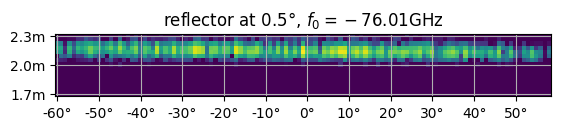

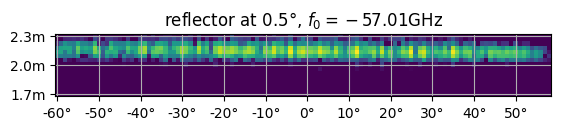

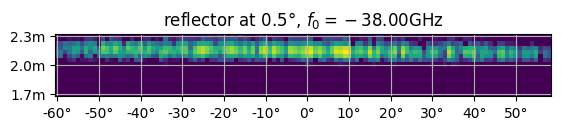

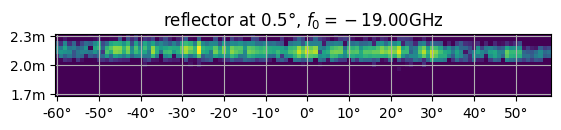

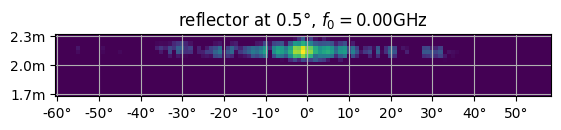

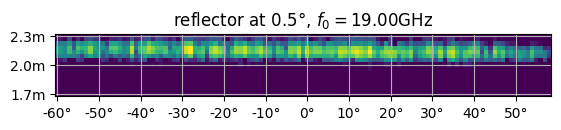

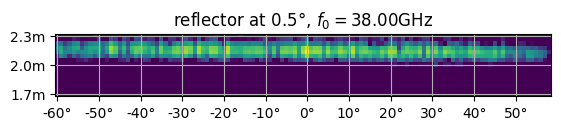

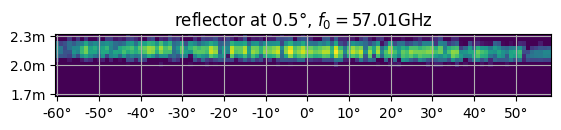

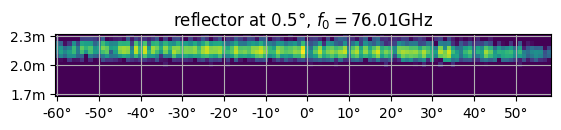

In [32]:
torch.Tensor.to_dbr = lambda self : 20*self.abs().log10() - 20*self.abs().max().log10()

for f in torch.linspace(-f_start, f_start, 9):
    gain_shifted = gain[:,:,None] * torch.exp(1j*2*pi*f * (tau-tau_meas[:,:,None])) # K,L,R
    weights = gain_shifted[None,:,:,:]\
            * torch.exp(1j*beta*tau[None,:,:,:]\
            * torch.arange(M)[:,None,None,None] * Ts)\
            * torch.hann_window(M)[:,None,None,None]
    for l in (L//2,):
    #for l in range(0,L,20):
        img = torch.empty(R,L)
        for r in range(R):
            img[r,:] = (data[:,:,l,None] * weights.conj()[:,:,:,r]).sum((0,1)).abs()
        plt.imshow(img.to_dbr(), origin='lower', vmin=-40)
        plt.xticks(range(0,L, 10), [f'{int(round(180*float(angle[l])/pi, -1))-90}°' for l in range(0,L, 10)])   
        plt.yticks(range(0,R, R//2), [f'{sampledists[r].float():.1f}m' for r in range(0,R, R//2)])
        plt.title(f'reflector at {round(180*float(angle[l])/pi, 1)-90:.1f}°, $f_0 = {f/1e9:.2f}$GHz')
        plt.grid()
        plt.show()